# Understanding relations between variables 
## A gentle introduction to correlation and regression for historians 
### ... in Python and Pandas

This chapter turns to more advanced but also more scientifically interesting and contested topics for historians. We will discuss the topic of modelling using linear or generelaized linear models.

This is only an introduction, as with the previous lecture we propose further reading, but

- What are doing when building a regression model?
- How to square the mechanistic assumptions and functions of a model with and historical (or just common sense) knowledge and reasoning?

More practically:

- How to train and intepret a model?

## Understanding relations between variables: Age and Wealth in late Victorian London

In this lecture we continue building on the data we used previously: we'd like to investigate the distribution of age in London, but explaining and predicting variation in age.

We are specifically interesting in the relation between wealth and age. We have two two dataframes
- the mean each in each district (aggregated by gender)
- the rateable value per capita for each borough

The first case study discussed in this lecture should not be interpreted as realistic research example, it is too problematic for that. However, we hope it will demonstrate multiple practical and philosophical problems (and opportunities) that aries when applying regression to historical data and questions.

Of course, the first step is the load the required tool we will need later on in this notebook.

In [291]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import matplotlib.pyplot as plt
sns.set()

Before we turn to the actual analysis, let's discuss some common data wrangling steps that characterize, and often problematize, data rich research in history. 

First we create a new dataframe the records the mean age and number of observiations for each district.

In [305]:
df = pd.read_csv('data/icem/EW01_london_subsample.csv',index_col=0)
df.head()

,RegDist,SubDist,Sex,Age,DisCode1
0,Kensington,Kensington Town,M,18,0
1,Greenwich,Deptford South,U,14,0
2,St George Hanover Square,St Margaret And St John,M,38,0
3,St Olave Southwark,Bermondsey,F,42,0
4,St George Hanover Square,St Margaret And St John,M,19,0


In [353]:
age_by_dist = df.groupby(['RegDist']).agg({'Age':'mean','Sex':'count'})

In [354]:
age_by_dist

,Age,Sex
RegDist,,
Bethnal Green,25.608299,31593
Camberwell,27.271123,63060
Chelsea,30.861967,18329
Fulham,27.189886,60489
Greenwich,26.939173,44832
Hackney,28.049584,65687
Hampstead,29.369687,20117
Holborn,27.419349,31320
Islington,28.222900,81826


We can do the same but now disagregating by gender.

In [355]:
age_by_dist_gen = df.groupby(['RegDist','Sex']).agg({'Age':'mean','Sex':'count'})

In [356]:
age_by_dist_gen

Age    Sex
RegDist       Sex                  
Bethnal Green F    25.920963  16081
              M    25.613501  14458
              U    20.766603   1054
Camberwell    F    27.986109  32898
              M    26.708931  28172
...                      ...    ...
Whitechapel   M    26.254569   9357
              U    24.051316    760
Woolwich      F    26.653639  15250
              M    26.311769  15643
              U    21.427165   1016

[90 rows x 2 columns]

To understand the relation between how wealthy a place is and the average age of the people living in that location we need to add additional information to our dataframe. 

The dataframe below capture the rateable value per capita in each London borough (the data is synthetic but follows the pattern of a 'real' values collected for 1922.

Rateable value per capita is proxy for [...].

The latter is something prevalent in statistical research where we use variables as standing in for some phenomemen you want to explain. This topic is also called **construct validity**.

In [357]:
rv = pd.read_csv('./data/icem/rateable_value.csv',index_col=0)
rv.head()

,borough,rateable_value_pc
0,Battersea,6.1
1,Bermondsey,8.5
2,Bethnal Green,4.9
3,Camberwell,5.2
4,Chelsea,14.7


We want to merge the dataframes together but first we should check to what extent this is possible, both practically and theoretically.

- What names occur in both datasets? We will use these to combine information from heterogeneous sources.
- To what extent are the districts that appear in the census the same as the boroughs in the data on rateable value per capita?

First we want check which place names appear in both datasets

We create a Python `set`, a list of unique values, for the place names in both dataframes.

We first take the column that records place names and  we convert this to a set of unique names.

In [311]:
d1_pl = set(df['RegDist'])
print(d1_pl)

{'St George Hanover Square', 'Pancras', 'Shoreditch', 'Poplar', 'Stepney', 'Chelsea', 'Hackney', 'Camberwell', 'Lambeth', 'Lewisham', 'St George In The East', 'Kensington', 'Westminster', 'Bethnal Green', 'St Giles', 'Paddington', 'London City', 'Holborn', 'Hampstead', 'St Olave Southwark', 'Islington', 'Marylebone', 'Strand', 'Greenwich', 'Southwark', 'Mile End Old Town', 'Fulham', 'Wandsworth', 'Woolwich', 'Whitechapel'}


In [312]:
d2_pl = set(rv['borough'])
print(d2_pl)

{'Battersea', 'Deptford', 'Pancras', 'Shoreditch', 'Poplar', 'Stepney', 'Chelsea', 'Hackney', 'Stoke Newington', 'Camberwell', 'Lambeth', 'Lewisham', 'Hammersmith', 'Bermondsey', 'Finsbury', 'Kensington', 'Westminster', 'Bethnal Green', 'Paddington', 'Holborn', 'Hampstead', 'Islington', 'Marylebone', 'Greenwich', 'Fulham', 'Southwark', 'Wandsworth', 'Woolwich'}


After getting these two sets we compute their intersection, i.e. the names that appear in both dataframes.

The syntax is set1.intersection(set2). We basically apply the `.intersection()` to a set and pass another set as argument.

In [313]:
print(d1_pl.intersection(d2_pl))

{'Pancras', 'Shoreditch', 'Poplar', 'Stepney', 'Chelsea', 'Hackney', 'Camberwell', 'Lambeth', 'Lewisham', 'Kensington', 'Westminster', 'Bethnal Green', 'Paddington', 'Holborn', 'Hampstead', 'Islington', 'Marylebone', 'Greenwich', 'Fulham', 'Southwark', 'Wandsworth', 'Woolwich'}


In [314]:
d1_pl - d2_pl

{'London City',
 'Mile End Old Town',
 'St George Hanover Square',
 'St George In The East',
 'St Giles',
 'St Olave Southwark',
 'Strand',
 'Whitechapel'}

In [315]:
d2_pl - d1_pl

{'Battersea',
 'Bermondsey',
 'Deptford',
 'Finsbury',
 'Hammersmith',
 'Stoke Newington'}

Now we can go ahead and merge the data. However, be careful: it is not because the strings match that they mean the same thing. Don't worry about the syntax we will explain it in more detail below.

In [316]:
data_merged = age_by_dist.merge(rv,left_index=True,right_on='borough')
data_merged

,Age,index,borough,rateable_value_pc
2,25.642209,62788,Bethnal Green,4.9
3,27.311895,126286,Camberwell,5.2
4,31.009385,36443,Chelsea,14.7
7,27.181759,120924,Fulham,6.1
8,26.912896,90375,Greenwich,7.6
9,27.974470,131922,Hackney,5.7
11,29.357228,40260,Hampstead,13.3
12,27.150275,62532,Holborn,32.0
13,28.205897,163256,Islington,5.7
14,30.203241,86636,Kensington,14.4


`.merge` is a very, very useful method to combine dataframes based on shared information. More precisely, a shared variable or columns. What we did in the previous code, was adding information from `rv` to `age_by_dist`. As we shown before, both share a columns that have similar values, namely place names in London. We use the values to combine dataframes, i.e. rows that have the value `Bethnal Green` in the `age_by_dist` dataframes will be joined by those

Please notice that the name of the columns can be different but the values in the columns have to overlap.

Below we show a simple toy example slight adapted from very thorough Pandas [documentation](https://pandas.pydata.org/docs/reference/api/pandas.merge.html).

Imagine that I recorded the number of cats and dogs I spotted each day, but keep this information in two separate dataframes.

In [317]:
df1 = pd.DataFrame({'day': ['mon', 'tue', 'wed', 'thu'],
                    'cats': [1, 2, 3, 5]})
df2 = pd.DataFrame({'dayz': ['mon', 'tue', 'wed', 'thu'],
                    'dogs': [5, 6, 7, 8]})

In [318]:
df1

,day,cats
0,mon,1
1,tue,2
2,wed,3
3,thu,5


In [319]:
df2

,dayz,dogs
0,mon,5
1,tue,6
2,wed,7
3,thu,8


As you notice both dataframes have a column that records that day of the week, even though the column name slightly differz. We can combine these dataframes into one with `left_df.merge(right_df)` method. This method is apply to a dataframe at the left hand side (before the dot) and one at the right hand side passed as an argument to the method.

To merge properly, we have to instruct Pandas by telling which columns we want to use for combining information. `left_on` indicates the column name we use in the dataframe at the left hand side of the `.merge()` method.

In [320]:
df1.merge(df2, left_on='day', right_on='dayz')

,day,cats,dayz,dogs
0,mon,1,mon,5
1,tue,2,tue,6
2,wed,3,wed,7
3,thu,5,thu,8


Sometimes we want merge using the index of a dataframe instead of a column. In this case we use the argument `left_index` (or `right_index`) and takes a boolean (`True` or `False` as value).

To revisit a previous line of code, which should be more understable at this point: the line below merges `age_by_dist` (left) with `rv`. For the left dataframe we use the index (`left_index=True`), for the right one a column named `'borough'` (`right_on='borough'`).

In [321]:
data_merged = age_by_dist.merge(rv,left_index=True,right_on='borough')
data_merged

,Age,index,borough,rateable_value_pc
2,25.642209,62788,Bethnal Green,4.9
3,27.311895,126286,Camberwell,5.2
4,31.009385,36443,Chelsea,14.7
7,27.181759,120924,Fulham,6.1
8,26.912896,90375,Greenwich,7.6
9,27.974470,131922,Hackney,5.7
11,29.357228,40260,Hampstead,13.3
12,27.150275,62532,Holborn,32.0
13,28.205897,163256,Islington,5.7
14,30.203241,86636,Kensington,14.4


##  Correlation

Having combined information from these dataframes, we can explore the relation between variables. Let's start with the most the most obvious point: correlation. 

Correlation tells us the extent to which two variables are related. Imagine I collect the number of dogs I observed in a variable `v1` and the daily cats in `v2`. If there is a correlation between cats and dogs on the street, I expect the to see many (of few) dogs and cats on the same days, or if the number of daily spotted dogs is up, so does the number of cats.

To inspect the correlation visually we can make a scatterplot. This plots for each value in `v1` the corresponding value in `v2`. For example the first point in the figure below looks at the first value in both vector. The x value is 1 and the y value is 2 producing at point (1,2). **[rephrase]**

In [425]:
v1 = [1,3,5,7,2,6]
v2 = [2,4,8,7,3,5]

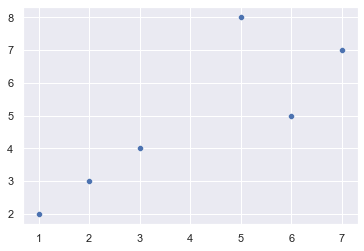

In [426]:
sns.scatterplot(x=v1,y=v2)

The figure suggests a strong correlation between `v1` and `v2`, i.e. we observe hight values for y when x is high. 

However nice, we'd like to put a number on this, the expressess the strength of this relation, so we can compare if other vectors are stronger correlated.


We can compute the strength of this relation between using Pearson correlation coefficient.

Please notice that computing correlation is based on an implicit alignment of the tow vectors. Each position captures the same days. If the order in v2 would be different (for example starts at Wednesday) I could technically still make a scatterplot and computer correlation but the results would be meaningless (or at least not match the intention).


### Pearson correlation coefficient

A widely used measure to compute the relation between to arrays or vectors is the pearsion correlation coefficient. This coefficient will vary between -1 and +1, meaning a strong negative respectively positive correlation.


Below we will show how to compute it yourself, but as you can guess, there exist method in Pandas.

However, showing the process is good to demystify such measures.

We need a few ingredients to compute the pearson correlation coeffient. First we need to compute the mean for each vector and their standard deviation. We also need to normalize by the amount of data we have, for this we need to record `n` the number of observations (this is equaly to the length of `v1` (or `v2`, remember both are aligned and equal in length).

In [427]:
mean_v1 = np.mean(v1)
mean_v2 = np.mean(v2)
std_v1 = np.std(v1)
std_v2 = np.std(v2)
n = len(v1)

Next, for each vector we substract each value with the mean of the vector

In [428]:
sub_mean_v1 = [i - mean_v1 for i in v1]
sub_mean_v2 = [i - mean_v2 for i in v2]

In [429]:
sub_mean_v1,sub_mean_v2

([-3.0, -1.0, 1.0, 3.0, -2.0, 2.0],
 [-2.833333333333333,
  -0.833333333333333,
  3.166666666666667,
  2.166666666666667,
  -1.833333333333333,
  0.16666666666666696])

Then we compute the position-wise product of the value in `sub_mean_v1` and `sub_mean_v2`, i.e we we multiple the first position in `sub_mean_v1` with the value in the corresponding postion in `sub_mean_v1`.

A convenient function here is `zip()` which as the name suggest zips two lists based on the index. For example if we `zip` `sub_mean_v1` and `sub_mean_v1` we get:

In [430]:
diffs_zipped = list(zip(sub_mean_v1,sub_mean_v2))
diffs_zipped

[(-3.0, -2.833333333333333),
 (-1.0, -0.833333333333333),
 (1.0, 3.166666666666667),
 (3.0, 2.166666666666667),
 (-2.0, -1.833333333333333),
 (2.0, 0.16666666666666696)]

Each element in the list `diffs_zipped` is a tuple. Next we multiply the elements in each tuple and sum all the values.

In [431]:
products = [i*j for i,j in diffs_zipped]
products

[8.5,
 0.833333333333333,
 3.166666666666667,
 6.500000000000001,
 3.666666666666666,
 0.3333333333333339]

Now we can compute the nominator of the pearson correlation coefficient, by taking the sum of these products.

In [432]:
nominator = sum(products)
nominator

23.0

To obtain the coefficient we divide the nominator by the product of the standard deviations and the number of observiations

In [433]:
denominator = std_v1 * std_v2 * len(v1)

In [434]:
nominator / denominator

0.8390957231764806

Looking closer at these steps you can intuitively grasp what the determines the strength of the coerration. Looking at `diffs_zipped` and `product` you observe that if two values (at the same position) equally differ from the mean this will result in higher products (remember from hight school that the product of two negative numbers is positive!) and produces a higher values for the nominator. For yourself, you can establish that when the difference from the mean but in an opposite direction wil result in negative nominator.

Of course you can skip these steps, as Pandas provide you with a method `.corr()` to compute correlation between two series. Below we first convert each vector to an instance of `pd.Series` and then calculate the correlation coefficient, which, too no surprise, should be exactly the same!

Of course, now we can also compute the relation between age and wealth.

In [437]:
data_merged['Age'].corr(data_merged['rateable_value_pc'])

0.3543273581913075

Actually, that's quite a low correlation!

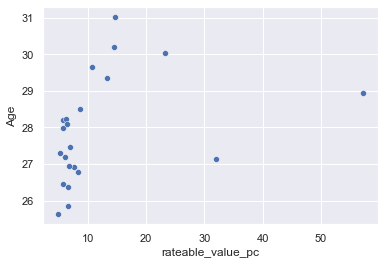

In [438]:
sns.scatterplot(x='rateable_value_pc',y='Age',data=data_merged)

### Spearman correlation

As any statistics text will tell you, there are many different ways to compute correlation between variables and depending on your research some will be more valid then others. 

Pearson takes into accounts the differences between the number of cats and dogs. But imagine, that I care are more if I spot more of these animals on the same day. In this case I care more about the rank correlation. 
**[explain a bit better]**

We compute this using the Spearman rank correlation.

In [439]:
v1_ranked = {v:i+1 for i,v in enumerate(sorted(v1))}
v1_rank = [v1_ranked[i] for i in v1]
v1, v1_rank

([1, 3, 5, 7, 2, 6], [1, 3, 4, 6, 2, 5])

In [412]:
v2_ranked = {v:i+1 for i,v in enumerate(sorted(v2))}
v2_rank = [v2_ranked[i] for i in v2]
v2_rank

[1, 3, 6, 5, 2, 4]

In [413]:
mean_v1 = np.mean(v1_rank)
mean_v2 = np.mean(v2_rank)

In [414]:
nominator = np.sum([(i1 - mean_v1)*(i2 - mean_v2) for i1,i2 in zip(v1_rank,v2_rank)])

In [415]:
denominator = np.std(v1_rank) * np.std(v2_rank) * len(v2_rank)

In [416]:
nominator/denominator

0.8285714285714286

In [417]:
pd.Series(v1).corr(pd.Series(v2), method='spearman')

0.8285714285714287

In [423]:
data_merged['Age'].corr(data_merged['rateable_value_pc'],method='spearman')

0.5511591990565328

Even those who don't engage with statistics, have heard that correlation doesn't mean causation, and is often called 'spurious'. 
Correlation doesn't mean that two variables are associated in the 'real world' (and the opposite: the lack of correlation doesn't mean there is no meaningfull relation between variables).

There is even a website on this topic: https://www.tylervigen.com/spurious-correlations

Be careful when making claims based on the correlation. As often, the statistsical experiment won't give you an answer to your question. There is no simple way to determine if a correlation is spurious, this depends on your domain and theoretical knowledge.


# Linear Regression

Whereas correlation tells you that two variables are related (albeit in a very superficial way) you can not tell more besides the fact the when X goes up we expect Y to do the same. If I see more dogs, I'm also expecting to notice more cats.

Regression modelling on the other hand will tell us more about the mechanistic relation between two variables: how many cats do I expect to see after on a day where I 

The mechanistic relationship allows us to predict a phenomena based on a number of what are usually called independent of predictor variables.

Returning to our example of age and wealth (goodby doggies, you were very helpful), we'd like to see if we can predict the average age (response) in a district given the rateable value per capita (predictor).

Notice here that we have to rely on common sense and domain expertise to construct model that make sense. We could also model the reverse, assuming that populating an area with younger people will affect rateable value. Of course, that also make sense in some universe and could be called reverse causality. 

However, in the way we framed the research (and again this a construction and based on construct validity) we framed as wealth having an impact on age: in poor district the people die younger, people dying younger doesn't make a place poorer. 

R -> A

and not 

R <- A

But these are assumption, (questionable) projections on the data. Oftentimes, when reading a historical paper that usess statistical methods, it is often more important to critically look at the relation between narrative and method (what is data supposed to capture (or mean) and how is combined into a causal theory).

Let's first discuss what a regression model does, before we continue with a more detailed discussion on how to run a regression model.

In it's simplest form a linear model we try to predict a value (age) based on a linear combination of another valie (rateable value per capita). We want to predict the former using the latter.

Using `seaborn` we can make a dispersion plot where each observation is turned into a point on the figure. The x-axis (`x=`) shows the rateable value, the y-axis (`y=`) age. 

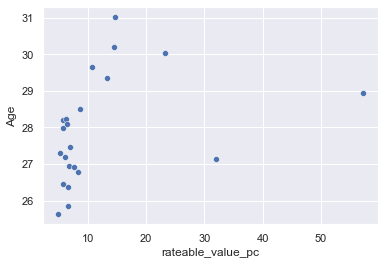

In [584]:
sns.scatterplot(x='rateable_value_pc',
                y='Age',
                data=data_merged)

How? Looking at the scatterplot the relation between the two is not obvious. In it's simplest, a linear regression will model the relation between x and y by drawing a line best "fits" the data, i.e. closest to the observations as possible.

From your high school you may remember the equation of a line.

y = a + b*x

age = intercept + slope * rateable value per capita

a is intercept, the point where the line crosses to y-axis if x is zero. You may also think as: what age do we expect for a place with zero rateable value.

b is the slope, and determinss the strength the y and x: how much change to we expect in y after one unit change x. What how many years do we expect to add moving from a place with rateable value 3 to 4 for example.

We know age and rateable value. We use these data to estimate the value of a (intercept) and b slope. We have a closer look at this later.

For now we plot the result, i.e. what the model thinks the line should look like after observing the data.

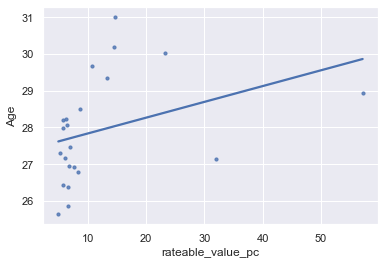

In [489]:
sns.regplot(x="rateable_value_pc", y="Age", 
                 data=data_merged,
                 scatter_kws={"s": 10},
                 order=1,ci=False)

The line plotted is based on a linear regression and is the line that fits best all observations. 

The fact that models "work", doesn't nesicarilly mean they make sense. A best fit can still be pretty bad.

As you observe there are many values cluttered together in the lower range and only a few at the right hand side of the figure.

We can improve the fit by transforming the values on a-axis. We take the natural logarthim of the rateable value per capite, this will make small differences (pull apart the observation at the lower end of independent variable) and large difference smaller (push those places at the far right to the other observations).

But what is the natural logarithm? Let's have a look, what happens if we take the logarithm of 1000

In [592]:
np.log(1000)

6.907755278982137

We get a number close to 7 (i.e. 6.907755278982137). What does this mean? The logarithm is inverse of exponentation: if x = log(y) and y = exp(x), or sticking to our example, if np.log(1000) produces 6.907755 then 
e<sup>6.90775</sup> will approximately equal 1000 (not exactly as rounded the numbers.
`e` is called Euler's number and is approximately equal to 2.71828182845904523536028747135266249775724709369995 according to [Wikipedia]. You can check this for yourself

In [601]:
np.exp(6.907755278982137)

999.9999999999998

In [602]:
np.power(2.71828,6.907755278982137)

999.9953534904313

But why we would we do this, why would we effectively rescale one our variables? This partly solves the problem of dispersion: the logarithmic scale can make linear modelling easier, as sometimes value becomes linear on a logarithmic scale. Below we first show a toy example using numbers that become increasingly separated.

In [630]:
x_1 = [10,100,1000,10000]

As you seen it is very difficult to model sudden gaps with a linear line...

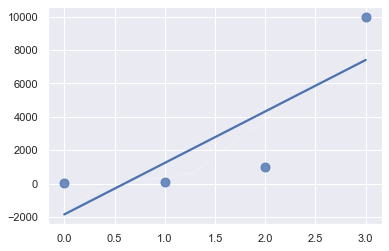

In [632]:
sns.regplot(x=list(range(len(x_1))), y=x_1, 
                 scatter_kws={"s": 80},
                 order=1,ci=False)

However, if we take the logarith, these values become neatly linear.

In [634]:
x_2 = np.log([10,100,1000,10000])

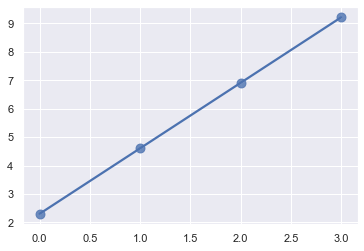

In [636]:
sns.regplot(x=list(range(len(x_2))), y=x_2, 
                 scatter_kws={"s": 80},
                 order=1,ci=False)

Even though 'real' data never fits patterns as neatly, we observe similar changes when inspecting the rateable value per capita variable.

In [637]:
data_merged.sort_values('rateable_value_pc',inplace=True)

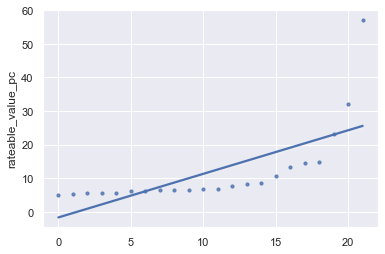

In [638]:
sns.regplot(x=list(range(22)), y=data_merged["rateable_value_pc"], 
                 scatter_kws={"s": 10},
                 order=1,ci=False)

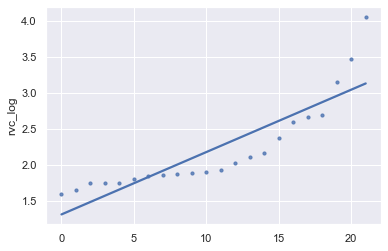

In [639]:
sns.regplot(x=list(range(22)), y=data_merged["rvc_log"], 
                 scatter_kws={"s": 10},
                 order=1,ci=False)

Both lines don't fit the data perfectly, however the later one does seem approximate the actual observed values better.

Also, if now model age as a function of the logged rateable value, we 

In [340]:
data_merged['rvc_log'] = np.log(data_merged['rateable_value_pc'])

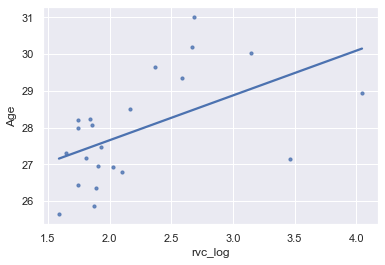

In [459]:
sns.regplot(x="rvc_log", y="Age", 
                 data=data_merged,
                 scatter_kws={"s": 10},
                 order=1,ci=False)

Later in this lecture we have a closer look and actually quantify the difference logging makes with respect to the goodness of fit. For now, a visual inspection suffices. Even though, we could add, that logging also improved the correlation between the two variables.

In [648]:
data_merged['rateable_value_pc'].corr(data_merged['Age'],method='pearson')

0.35432735819130734

In [649]:
data_merged['rvc_log'].corr(data_merged['Age'],method='pearson')

0.5353983955320823

Generally logging values doesn't harm, but you'll have to be careful as it influences your interpretation and the predictions to model will make. So you have to be carefull nonetheless. 

A closer look at the scatterplot and the data shown that two (or three) places have a signficantly higher rateable value: Holborn and Westminster, and also Marelybone. This is confirmed by the boxplot below.  

How to approach these observation: one albeit, very problematich approach is to consider them as outlier and remove them from the datasets.

This is a classical example of where interventions need to motivated or at least explained by domain expertise. Excluding the Holborn and Westminster has a huge effect on the slope of the regression line.

In [ ]:
data_merged[['borough','rateable_value_pc']]

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


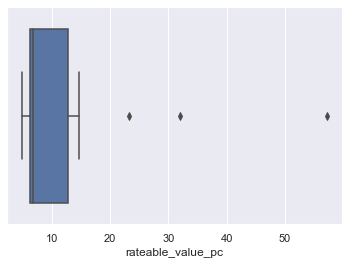

In [656]:
sns.boxplot(data_merged.rateable_value_pc)

Let's remove these districts to how they affect our model.

In [659]:
data_wo_outliers = data_merged[~data_merged.borough.isin(['Westminster',"Holborn"])]

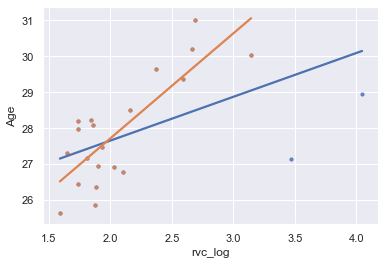

In [660]:
sns.regplot(x="rvc_log", y="Age", data=data_merged,
                 scatter_kws={"s": 10},
                 order=1,ci=False)

sns.regplot(x="rvc_log", y="Age", data=data_wo_outliers,
                 scatter_kws={"s": 10},
                 order=1,ci=False)

In the figure the orange line shows the regression line after removing the so-called 'outliers'. You see how throwing away information (i.e. observations) is tricky thing: yes it easier to model the relationship between the variables linearly. However, this comes at a cost, we won't be able to accurately say something about the wealthier districts, and (if we believe the orange 

However, if you're only interested in predicting the age for a certain type of boroughs, and have good reasons to believe the ones we throwns are qualitatively different and should be considered as seperate case studies, then yes, it could be allow the consider only certain boroughs.

In any case, it is important to know the a few place carry a lot of weight, i.e. the influence the slope of the regression lines substantially.


Again, here, or domain expertise has priority over statistics, and the statistics alone can not provide you with the answer of how to proceed and analyse your data.

In [662]:
print(data_merged['rvc_log'].corr(data_merged['Age']))
print(data_wo_outliers['rvc_log'].corr(data_wo_outliers['Age']))


0.5353983955320823
0.8055989190525026


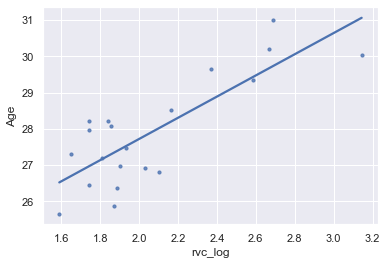

In [663]:
sns.regplot(x="rvc_log", y="Age", 
                 data=data_wo_outliers,
                 scatter_kws={"s": 10},
                 order=1,ci=False)

Hopefully, this largely visual introduction demonstrated the use of linear regression and some of problems that you are likely to encounter. Again, we'd like to stress that often the solution to these issues often require you to lean on your domain expertise as historian. To solutions are often not statistical. 

History always should come before statistics.

## Linear Regression (a closer look)

In the preceding section we approached the idea of linear regression from a more intuitive, visual perspective. In this section we have a closer look at the reading the results and outputs that accompany regression analysis. 

Performing a linear regression is rather straightforward with  the `statsmodels` package in Python. There a just a few things to be careful about. First we define the response variable, in this case 'Age'.

In [743]:
Y = data_merged['Age']

Next we select the independent variable from the dataframe.

In [744]:
X = data_merged['rateable_value_pc']

Now there is one small trick to keep in mind. As said earlier the equation of a simple linear model is 

$y = a + b*x$

In this equation we know both $y$ and $x$ these are data we observed. We don't know $a$ and $b$, these are the parameters we want to learn from the data. 

Running a regression will return an estimate for $a$ and $b$ most consistent with the observed data. 

Because we want `statsmodels` to estimate both the intercept $a$ and the slope $b$ we have to add one more column with only a constant to `X`. Luckily this is really straightforwards with the `add_constant` function.

In [745]:
X = sm.add_constant(X)
X 

,const,rateable_value_pc
0,1.0,4.9
1,1.0,5.2
2,1.0,5.7
3,1.0,5.7
4,1.0,5.7
5,1.0,6.1
6,1.0,6.3
7,1.0,6.4
8,1.0,6.5
9,1.0,6.6


Now we are ready instantiate the model and fit it. We save the result of the fitted model in the `results` variable.

In [746]:
model = sm.OLS(Y,X) # instantiate model
results = model.fit() # fit model

Applying the `.summary()` method to the fitted model will print a rather large report.

In [747]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     2.871
Date:                Thu, 20 Jan 2022   Prob (F-statistic):              0.106
Time:                        21:50:23   Log-Likelihood:                -37.580
No. Observations:                  22   AIC:                             79.16
Df Residuals:                      20   BIC:                             81.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                27.4098      0.425     64.488      0.000      26.523      28.296
rateable_value_pc     0.0429      0.025      1.695      0.106      -0.010       0.096
==============================================================================
Omnibus:                        1.375   Durbin-Watson:                   0.841
Prob(Omnibus):                  0.503   Jarque-Bera (JB):                1.238
Skew:                           0.473   Prob(JB):                        0.539
Kurtosis:                       2.326   Cond. No.                         23.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Most import values (for our purposes) are at the top right and the midde lines that report on the coefficients (`const` and `rvc_log`). Let's start with the latter, as these are most influential in the interpretations based on regression modelling.


`const 27.4098` means that for place with zero rateable value, we expect the average age to be around 25.2. This is the estimate for the intercept, i.e. the value of y (Age) when x (rateable value) = 0. 
`rateable_value_pc 0.0429` this is an estimate of the slape, the increase in y for one unit change in y: for example if the rateable value changes from 1 to 2 we expect the mean age to increase with 0.04 years. 

Now let's look at the other statistics reported here for these coefficients. Continuing with the estimate for `rateable_value_pc` the p-value is around 0.1 higher than the traditional 0.5 threshold commonly used in statistics. And the confidence intervals range from -0.010 to 0.096. 

Notice that this 0 is included in the confidence interval. A slope of zero means a horizontal line, and actually no change in y for x. The possibiliy that x and y are not related in any positive or negative way is well within the range of possibilities.

p-values and confidence remain rather abstract and difficult to explain, and statisticians tend to doubt their use. In human language, these number tells you how confident the model is about where to draw a line to best fit all observed variables. It is really shore that the intercepts is higher than zero, which is not surprising and probably somewhere between `26.523`	`28.296`. 

However, it is less confident about the slope, which can go down (-0.010) as well as up (0.096).

What happens if we fit a new model with logged rateable values values.

In [748]:
Y_2 = data_merged['Age']
X_2 = data_merged['rvc_log']
X_2 = sm.add_constant(X_2)
model_2 = sm.OLS(Y_2,X_2) # instantiate model
results_2 = model_2.fit() # fit model

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [749]:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     8.037
Date:                Thu, 20 Jan 2022   Prob (F-statistic):             0.0102
Time:                        21:50:26   Log-Likelihood:                -35.340
No. Observations:                  22   AIC:                             74.68
Df Residuals:                      20   BIC:                             76.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.2161      0.992     25.420      0.000      23.147      27.285
rvc_log        1.2195      0.430      2.835      0.010       0.322       2.117
==============================================================================
Omnibus:                        0.454   Durbin-Watson:                   1.063
Prob(Omnibus):                  0.797   Jarque-Bera (JB):                0.557
Skew:                           0.081   Prob(JB):                        0.757
Kurtosis:                       2.238   Cond. No.                         9.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Using the log-scale, change coefficients quite a lot especially for the rateable value. The model is now more certain the relation is postive and does not include the zero in the range of possibilities. 

For each change in x (the log of rateable value) we expect to add one year and a bit to `y` (1.2195). It is now a bit more difficult to understand, as the absolute change is bigger with each step in `x`.

In [740]:
np.exp(2), np.exp(3), np.exp(4)

(7.38905609893065, 20.085536923187668, 54.598150033144236)

This means that the model thinks that change in age is the same when going from a place with rateable value 7 to 20 as is transitioning from 20 to 54.

What all the statistics for the `const` and `rvc_log` are more formal ways for conveying where the model thinks the line should be.

We can make these results more intuitive using a "bootstrap" method. We construct the mean and confidence intervals repeatin the following steps, let's say 1000 times:
- sample a few observations from the data (50% in each iterations)
- fit the model and record the values for the intercept and the slope
- plot the line using these value or collect them and compute the 2.5 and 97.5 percentile range.

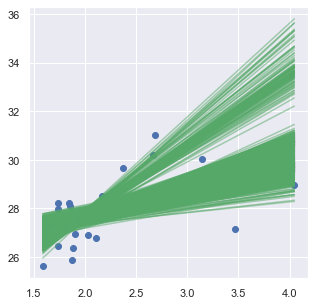

In [742]:
#data_merged.sort_values('re',inplace=True)
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter('rvc_log', 'Age',data=data_merged)
beta = []

for _ in range(1000):
    dms = data_merged.sample(frac=.66)
    Y_ = dms['Age']
    X_ = dms['rvc_log']
    X_ = sm.add_constant(X_)
    model_ = sm.OLS(Y_,X_)
    results_ = model_.fit() 
    beta.append(results_.params['rvc_log'])

    ax.plot(data_merged['rvc_log'], results_.params['const'] + (data_merged['rvc_log']*results_.params['rvc_log']) , '-g',alpha=.5)


0.025    0.742577
0.975    3.112409
dtype: float64

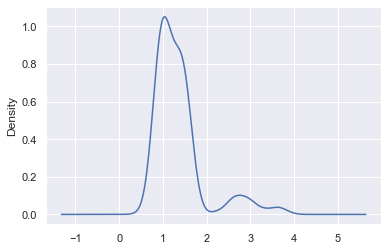

In [728]:
pd.Series(beta).plot(kind='density')
pd.Series(beta).quantile([.025,.975])

The values are not exactly the same because we have a small sample and only ran a few iterations. However it gives more intuitive way of understanding of what the p-values and confidence intervals mean. Instead of bootstrapping you can also compute the formula-based intervals with `statsmodels`.

In [738]:
pred = results_2.get_prediction(X_2)
df_pred = pd.DataFrame(pred.conf_int())
df_pred['mean'] = pred.predicted_mean

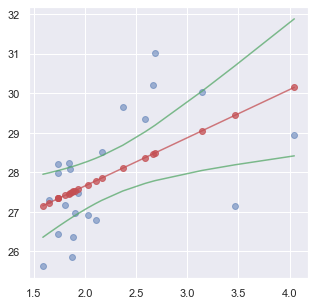

In [739]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(data_merged['rvc_log'], 'Age',data=data_merged,alpha=.5)
ax.plot(data_merged['rvc_log'], df_pred['mean']  , '-ro',alpha=.75)
ax.plot(data_merged['rvc_log'], df_pred[0]  , '-g',alpha=.75)
ax.plot(data_merged['rvc_log'], df_pred[1]  , '-g',alpha=.75)

Please notice that coeficients and their confidence intervals are estimates of the line not the actual data. These are, as you can see, well outside the range given by the predicted values and their confidence intervals.

The `.summary()` method provides other statistics that help you understanding how well the model performs.

In [751]:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     8.037
Date:                Thu, 20 Jan 2022   Prob (F-statistic):             0.0102
Time:                        21:55:10   Log-Likelihood:                -35.340
No. Observations:                  22   AIC:                             74.68
Df Residuals:                      20   BIC:                             76.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.2161      0.992     25.420      0.000      23.147      27.285
rvc_log        1.2195      0.430      2.835      0.010       0.322       2.117
==============================================================================
Omnibus:                        0.454   Durbin-Watson:                   1.063
Prob(Omnibus):                  0.797   Jarque-Bera (JB):                0.557
Skew:                           0.081   Prob(JB):                        0.757
Kurtosis:                       2.238   Cond. No.                         9.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

`RMSE`

In [784]:
pred = results_2.get_prediction(X_2)
Y_hat = pred.predicted_mean 
var_pred = [(y - y_hat)**2 for y,y_hat in zip(Y,Y_hat)] 

In [785]:
Y_hat

array([27.15414139, 27.22660598, 27.33856177, 27.33856177, 27.33856177,
       27.42126883, 27.46060972, 27.47981424, 27.498721  , 27.5173391 ,
       27.53567721, 27.57154632, 27.68937905, 27.78204095, 27.85421951,
       28.10655141, 28.37180908, 28.46871259, 28.49385702, 29.05030324,
       29.44246216, 30.15074748])

`R-squared`

In [780]:
np.sqrt(np.sum(var_pred) / len(Y))

1.2061592382790065

In [781]:
var_total = [(y - np.mean(Y))**2 for y,y_hat in zip(Y,Y_hat)] 

In [782]:
round(1 - (sum(var_pred)/sum(var_total)),3)

0.287

Text(0, 0.5, 'standardized residuals')

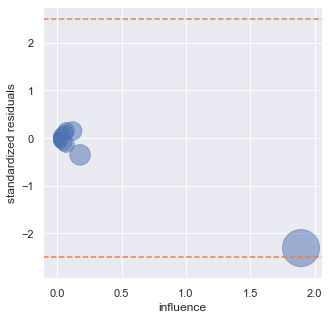

In [792]:
from statsmodels.stats.outliers_influence import OLSInfluence
influence = OLSInfluence(results)
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.cooks_distance[0], influence.influence,
s=1000 * np.sqrt(influence.cooks_distance[0]),
alpha=0.5)
ax.set_xlabel('influence')
ax.set_ylabel('standardized residuals')

In [575]:
data_merged.iloc[np.argmax(influence.hat_diag_factor)]

level_0                       26
Age                    28.948076
index                      16139
borough              Westminster
rateable_value_pc           57.2
rvc_log                 4.046554
Name: 21, dtype: object

In [802]:
Y_woo = data_wo_outliers['Age']
x_woo = data_wo_outliers['rvc_log']
#X_woo = np.column_stack((x_woo, np.log(data_wo_outliers['index'])))
X_woo = sm.add_constant(x_woo)
model_woo = sm.OLS(Y_woo,X_woo)
results_woo = model_woo.fit()

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [803]:
results_woo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     33.28
Date:                Thu, 20 Jan 2022   Prob (F-statistic):           1.82e-05
Time:                        22:47:46   Log-Likelihood:                -25.614
No. Observations:                  20   AIC:                             55.23
Df Residuals:                      18   BIC:                             57.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.8726      1.066     20.510      0.000      19.632      24.113
rvc_log        2.9228      0.507      5.769      0.000       1.858       3.987
==============================================================================
Omnibus:                        5.011   Durbin-Watson:                   1.653
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                1.565
Skew:                          -0.104   Prob(JB):                        0.457
Kurtosis:                       1.645   Cond. No.                         13.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

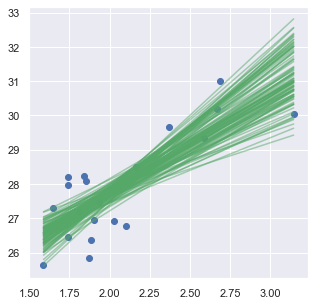

In [810]:
wo_outliers.sort_values('rvc_log',inplace=True)
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter('rvc_log', 'Age',data=wo_outliers)
beta = []
for _ in range(100):
    dms = wo_outliers.sample(frac=.5)
    Y = dms['Age']
    X = dms['rvc_log']
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit() 
    beta.append(results.params['rvc_log'])

    ax.plot(wo_outliers['rvc_log'], results.params['const'] + (wo_outliers['rvc_log']*results.params['rvc_log']) , '-g',alpha=.5)


0.025    1.922558
0.975    4.239305
dtype: float64

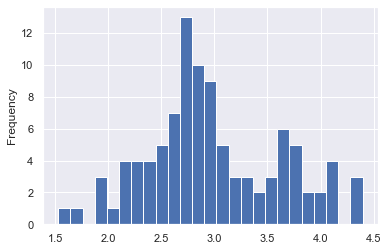

In [813]:
pd.Series(beta).plot(kind='hist',bins=25)
pd.Series(beta).quantile([.025,0.975])

In [469]:
wo_outliers['predictions'] = results.predict(X)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [815]:
Y_mr = data_merged['Age']
x_mr = data_merged['rvc_log']
X_mr = np.column_stack((x_mr, np.log(data_merged['index'])))
X_mr = sm.add_constant(X_mr)
model_mr = sm.OLS(Y_mr,X_mr)
results_mr = model_mr.fit()

In [816]:
results_mr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     4.888
Date:                Thu, 20 Jan 2022   Prob (F-statistic):             0.0194
Time:                        22:51:13   Log-Likelihood:                -34.490
No. Observations:                  22   AIC:                             74.98
Df Residuals:                      19   BIC:                             78.25
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.3268      7.259      2.249      0.037       1.135      31.519
x1             1.6264      0.537      3.027      0.007       0.502       2.751
x2             0.7111      0.575      1.236      0.232      -0.493       1.915
==============================================================================
Omnibus:                        1.338   Durbin-Watson:                   1.066
Prob(Omnibus):                  0.512   Jarque-Bera (JB):                0.367
Skew:                           0.258   Prob(JB):                        0.832
Kurtosis:                       3.366   Cond. No.                         315.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [822]:
data_merged['predictions'] = results_mr.predict(X_mr)

In [823]:
len(predictions),len(data_merged)

(22, 22)

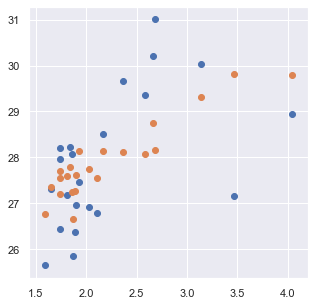

In [828]:

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter('rvc_log', 'Age',data=data_merged)
ax.scatter('rvc_log', 'predictions',data=data_merged)

### Categorical Variables

In [716]:
df['F'] = pd.get_dummies(df['Sex'])['F']

In [486]:
df_fm = df[(df.Sex.isin(['F','M'])) & (df.RegDist=='Stepney')]

In [487]:
Y = df_fm['Age']
X = df_fm['F']
#X = np.column_stack((x, x ** 2,x ** 3))
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

In [488]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.119
Date:                Tue, 18 Jan 2022   Prob (F-statistic):              0.290
Time:                        17:40:32   Log-Likelihood:                -58242.
No. Observations:               13459   AIC:                         1.165e+05
Df Residuals:                   13457   BIC:                         1.165e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.3201      0.224    117.353      0.000      25.880      26.760
F             -0.3343      0.316     -1.058      0.290      -0.954       0.285
==============================================================================
Omnibus:                      892.983   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1018.276
Skew:                           0.653   Prob(JB):                    7.66e-222
Kurtosis:                       2.668   Cond. No.                         2.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Predicting Counts

## Gender bias in university admissions?

In [281]:

data = pd.read_csv('/Users/kbeelen/Documents/OtherProjects/BayesianModelling/UCBadmit.csv',sep=';')
data.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [282]:
data['gid'] = pd.Categorical(data['applicant.gender']).codes 
data['did'] = pd.Categorical(data['dept']).codes 
data.head()

,dept,applicant.gender,admit,reject,applications,gid,did
1,A,male,512,313,825,1,0
2,A,female,89,19,108,0,0
3,B,male,353,207,560,1,1
4,B,female,17,8,25,0,1
5,C,male,120,205,325,1,2


In [283]:
data['gender'] = data['applicant.gender']

In [284]:
#https://timeseriesreasoning.com/contents/binomial-regression-model/


In [285]:
formula = 'admit +  reject ~ C(gender) + C(did)'
mod1 = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
print(mod1.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     ['admit', 'reject']   No. Observations:                   12
Model:                             GLM   Df Residuals:                        5
Model Family:                 Binomial   Df Model:                            6
Link Function:                   logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -44.572
Date:                 Mon, 17 Jan 2022   Deviance:                       20.204
Time:                         23:02:32   Pearson chi2:                     18.8
No. Iterations:                      6                                         
Covariance Type:             nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6819

In [286]:
data[['female','male']] = pd.get_dummies(data['applicant.gender'])

In [287]:
data

,dept,applicant.gender,admit,reject,applications,gid,did,gender,female,male
1,A,male,512,313,825,1,0,male,0,1
2,A,female,89,19,108,0,0,female,1,0
3,B,male,353,207,560,1,1,male,0,1
4,B,female,17,8,25,0,1,female,1,0
5,C,male,120,205,325,1,2,male,0,1
6,C,female,202,391,593,0,2,female,1,0
7,D,male,138,279,417,1,3,male,0,1
8,D,female,131,244,375,0,3,female,1,0
9,E,male,53,138,191,1,4,male,0,1
10,E,female,94,299,393,0,4,female,1,0


In [288]:
logistic(0.6104) - .5

NameError: name 'logistic' is not defined

In [155]:
logistic(-0.0999) -.5

-0.02495424981264921

In [171]:
formula = 'admit +  reject ~ female + male + C(did)'
mod1 = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
print(mod1.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     ['admit', 'reject']   No. Observations:                   12
Model:                             GLM   Df Residuals:                        5
Model Family:                 Binomial   Df Model:                            6
Link Function:                   logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -44.572
Date:                 Sun, 09 Jan 2022   Deviance:                       20.204
Time:                         22:20:51   Pearson chi2:                     18.8
No. Iterations:                      6                                         
Covariance Type:             nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.4213      0.050      8

In [166]:
logistic(-0.4803)

0.38218128710219784

In [167]:
logistic(0.1301)

0.532479200978304

In [182]:
logit = lambda  p:  np.log(p / (1 - p))

In [183]:
logistic = lambda lt: np.exp(lt) / (np.exp(lt) + 1)

In [188]:
round(logistic(logit(.6)),2)

0.6

In [185]:
exp()

NameError: name 'exp' is not defined

In [168]:
logistic(-0.4803) - logistic(0.1301)

-0.1502979138761062

In [195]:
logistic(-0.2606) - .5

-0.0647837793686441

In [ ]:
formula = 'admit +  reject ~ female + male'
mod1 = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
print(mod1.summary())

In [158]:
logistic(- 2.6526) -.5

-0.4341710593886168

In [15]:
exog = data[['gid','did','applications']].values
exog

array([[  1,   0, 825],
       [  0,   0, 108],
       [  1,   1, 560],
       [  0,   1,  25],
       [  1,   2, 325],
       [  0,   2, 593],
       [  1,   3, 417],
       [  0,   3, 375],
       [  1,   4, 191],
       [  0,   4, 393],
       [  1,   5, 373],
       [  0,   5, 341]])

In [ ]:
endog = data[]

## Gender and parliamentary questions

In [3]:
#!pip3 install seaborn==0.11.2

In [204]:
df = pd.read_csv('data/questions/parl_questions.csv',index_col=0,
                 parse_dates=["dob",'date tabled'],
                date_parser= lambda x: pd.to_datetime(x, format="%Y-%m-%"))

In [205]:
df.head()

,uri,answer date,answer date time,answering body,commons question time > question type,location > pref label,question status,ballot number,date tabled,modified,...,tabling member > uri,tabling member > constituency > pref label,tabling member printed,uin,tabling member,gender,party,uri_mp,dob,uri_dob
0,http://data.parliament.uk/resources/1388433,2022-01-05,2022-01-05T00:00:00,Prime Minister,Substantive,House of Commons chamber,Tabled,5,2021-12-16,2021-12-16T14:51:06.915,...,http://data.parliament.uk/members/1601,Bromley and Chislehurst,Sir Robert Neill,904884.0,NaN,Male,Conservative,http://data.parliament.uk/members/1601,1952-06-24,http://data.parliament.uk/members/1601
1,http://data.parliament.uk/resources/1386494,2021-12-15,2021-12-15T00:00:00,Prime Minister,Substantive,House of Commons chamber,Tabled,9,2021-12-09,2021-12-15T09:09:06.008,...,http://data.parliament.uk/members/1601,Bromley and Chislehurst,Sir Robert Neill,904812.0,NaN,Male,Conservative,http://data.parliament.uk/members/1601,1952-06-24,http://data.parliament.uk/members/1601
2,http://data.parliament.uk/resources/1379254,2021-11-23,2021-11-23T00:00:00,Department of Health and Social Care,Topical,House of Commons chamber,Tabled,10,2021-11-17,2021-11-23T13:44:07.090,...,http://data.parliament.uk/members/1601,Bromley and Chislehurst,Sir Robert Neill,904329.0,NaN,Male,Conservative,http://data.parliament.uk/members/1601,1952-06-24,http://data.parliament.uk/members/1601
3,http://data.parliament.uk/resources/1351922,2021-09-06,2021-09-06T00:00:00,Department for Education,Substantive,House of Commons chamber,Tabled,9,2021-08-31,2021-09-06T15:32:44.687,...,http://data.parliament.uk/members/1601,Bromley and Chislehurst,Sir Robert Neill,903323.0,NaN,Male,Conservative,http://data.parliament.uk/members/1601,1952-06-24,http://data.parliament.uk/members/1601
4,http://data.parliament.uk/resources/1347152,2021-07-22,2021-07-22T00:00:00,"Department for Environment, Food and Rural Aff...",Substantive,House of Commons chamber,Tabled,13,2021-07-15,2021-08-18T17:06:49.789,...,http://data.parliament.uk/members/1601,Bromley and Chislehurst,Sir Robert Neill,903142.0,NaN,Male,Conservative,http://data.parliament.uk/members/1601,1952-06-24,http://data.parliament.uk/members/1601


In [206]:
df.shape

(36748, 22)

In [207]:
df['uri_mp'].unique().shape

(740,)

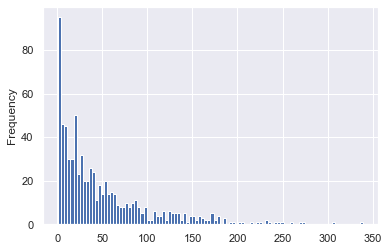

In [208]:
df.groupby('uri_mp')['uri'].count().plot(kind='hist',bins=100)

In [209]:
df.groupby(['uri_mp','answering body'])['uri'].count().groupby(level=0).apply(lambda x: x / x.sum())

uri_mp                                 answering body                              
http://data.parliament.uk/members/103  Department of Health and Social Care            0.500000
                                       Prime Minister                                  0.500000
http://data.parliament.uk/members/104  Department of Health and Social Care            0.071429
                                       Foreign and Commonwealth Office                 0.071429
                                       Foreign, Commonwealth and Development Office    0.071429
                                                                                         ...   
http://data.parliament.uk/members/93   HM Treasury                                     0.050000
                                       Home Office                                     0.025000
                                       Ministry of Defence                             0.050000
                                       Ministry of J

In [222]:
data_parl = df.groupby(['uri_mp','gender','party','answering body'])['uri'].count()
data_parl= data_parl.reset_index()
data_parl

,uri_mp,gender,party,answering body,uri
0,http://data.parliament.uk/members/103,Male,Conservative,Department of Health and Social Care,1
1,http://data.parliament.uk/members/103,Male,Conservative,Prime Minister,1
2,http://data.parliament.uk/members/104,Male,Conservative,Department of Health and Social Care,1
3,http://data.parliament.uk/members/104,Male,Conservative,Foreign and Commonwealth Office,1
4,http://data.parliament.uk/members/104,Male,Conservative,"Foreign, Commonwealth and Development Office",1
...,...,...,...,...,...
10984,http://data.parliament.uk/members/93,Male,Conservative,HM Treasury,2
10985,http://data.parliament.uk/members/93,Male,Conservative,Home Office,1
10986,http://data.parliament.uk/members/93,Male,Conservative,Ministry of Defence,2
10987,http://data.parliament.uk/members/93,Male,Conservative,Ministry of Justice,2


In [226]:
by_mp = df.groupby(['uri_mp'])['uri'].count()

In [227]:
data_parl = data_parl.merge(by_mp, left_on='uri_mp', right_index=True)

In [228]:
data_parl

,uri_mp,gender,party,answering body,uri_x,uri_y
0,http://data.parliament.uk/members/103,Male,Conservative,Department of Health and Social Care,1,2
1,http://data.parliament.uk/members/103,Male,Conservative,Prime Minister,1,2
2,http://data.parliament.uk/members/104,Male,Conservative,Department of Health and Social Care,1,14
3,http://data.parliament.uk/members/104,Male,Conservative,Foreign and Commonwealth Office,1,14
4,http://data.parliament.uk/members/104,Male,Conservative,"Foreign, Commonwealth and Development Office",1,14
...,...,...,...,...,...,...
10984,http://data.parliament.uk/members/93,Male,Conservative,HM Treasury,2,40
10985,http://data.parliament.uk/members/93,Male,Conservative,Home Office,1,40
10986,http://data.parliament.uk/members/93,Male,Conservative,Ministry of Defence,2,40
10987,http://data.parliament.uk/members/93,Male,Conservative,Ministry of Justice,2,40


In [252]:
data_parl['not_body'] = data_parl['uri_y'] -  data_parl['uri_x'] 

In [253]:
data_parl['answering body'].unique()

array(['Department of Health and Social Care', 'Prime Minister',
       'Foreign and Commonwealth Office',
       'Foreign, Commonwealth and Development Office', 'Home Office',
       'Ministry of Defence', 'Women and Equalities',
       'Department for Communities and Local Government',
       'Department for Education',
       'Department for Environment, Food and Rural Affairs',
       'Department of Health', 'Attorney General', 'COP26',
       'Cabinet Office', 'Church Commissioners',
       'Department for Business, Energy and Industrial Strategy',
       'Department for Business, Innovation and Skills',
       'Department for Culture, Media and Sport',
       'Department for Digital, Culture, Media and Sport',
       'Department for Energy and Climate Change',
       'Department for Exiting the European Union ',
       'Department for International Development',
       'Department for International Trade', 'Department for Transport',
       'Department for Work and Pensions', 'De

In [285]:
body = 'Department for Energy and Climate Change'#'Department for Exiting the European Union'#'Ministry of Defence'# 'Women and Equalities'
df_body = data_parl[(data_parl['answering body']==body) & (data_parl.party.isin(['Conservative','Labour']))]
df_body

,uri_mp,gender,party,answering body,uri_x,uri_y,not_body
23,http://data.parliament.uk/members/114,Male,Conservative,Department for Energy and Climate Change,1,118,117
50,http://data.parliament.uk/members/116,Male,Conservative,Department for Energy and Climate Change,1,34,33
100,http://data.parliament.uk/members/12,Female,Labour,Department for Energy and Climate Change,1,52,51
136,http://data.parliament.uk/members/136,Male,Conservative,Department for Energy and Climate Change,4,10,6
142,http://data.parliament.uk/members/1383,Male,Labour,Department for Energy and Climate Change,1,17,16
...,...,...,...,...,...,...,...
10880,http://data.parliament.uk/members/605,Male,Labour,Department for Energy and Climate Change,7,37,30
10900,http://data.parliament.uk/members/62,Male,Labour,Department for Energy and Climate Change,4,24,20
10916,http://data.parliament.uk/members/636,Female,Labour,Department for Energy and Climate Change,1,16,15
10936,http://data.parliament.uk/members/69,Male,Conservative,Department for Energy and Climate Change,1,35,34


In [307]:
formula = 'uri_x + not_body ~ C(gender) + C(party)'
mod1 = smf.glm(formula=formula, data=df_body, family=sm.families.Binomial()).fit()
print(mod1.summary())

                   Generalized Linear Model Regression Results                   
Dep. Variable:     ['uri_x', 'not_body']   No. Observations:                  212
Model:                               GLM   Df Residuals:                      209
Model Family:                   Binomial   Df Model:                            2
Link Function:                     logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -432.52
Date:                   Sun, 09 Jan 2022   Deviance:                       329.35
Time:                           23:16:11   Pearson chi2:                     523.
No. Iterations:                        7                                         
Covariance Type:               nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Interc

In [301]:
mod1.pvalues

Intercept             7.687015e-231
gender[T.Male]         2.308249e-01
C(party)[T.Labour]     1.504530e-02
dtype: float64

In [302]:
print(logistic(mod1.params['gender[T.Male]']) - .5)
#print(logistic(-0.567) - .5,logistic(-0.256) - .5)

0.03196124921406451


AttributeError: 'GLMResults' object has no attribute 'mse_resid'

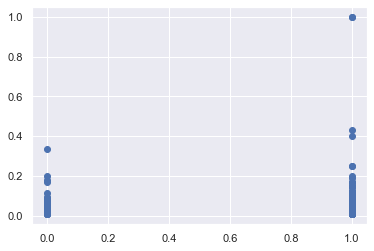

In [311]:
fig = sm.graphics.plot_fit(mod1, "C(gender)[T.Male]")
fig.tight_layout(pad=1.0)

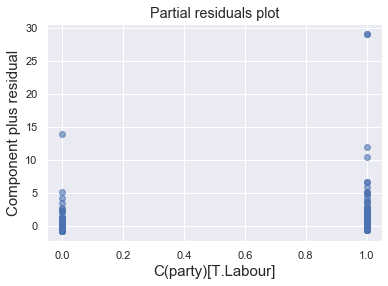

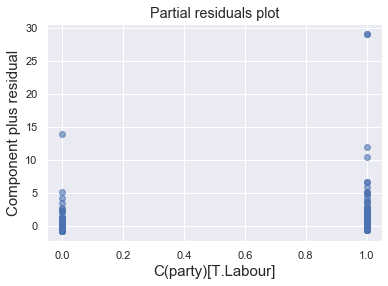

In [306]:
mod1.plot_partial_residuals('C(party)[T.Labour]')

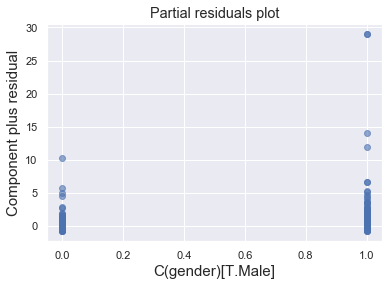

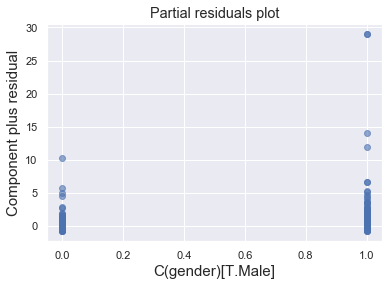

In [308]:
mod1.plot_partial_residuals('C(gender)[T.Male]')

In [289]:
formula = 'uri_x ~ C(gender) + C(party)'
mod1 = smf.glm(formula=formula, data=df_body, family=sm.families.Poisson(), exposure=df_body['uri_y']).fit()
print(mod1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  uri_x   No. Observations:                  212
Model:                            GLM   Df Residuals:                      209
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -430.67
Date:                Sun, 09 Jan 2022   Deviance:                       310.23
Time:                        23:11:37   Pearson chi2:                     506.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.7143      0

In [245]:
logistic(-0.3632) - .5

-0.08981484250963839

In [242]:
logistic(-0.3565) - .5

-0.08819291949925195

In [235]:
df.groupby(['uri_mp','gender'])['answering body'].apply(lambda x: len(set(x)))

uri_mp                                 gender
http://data.parliament.uk/members/103  Male       2
http://data.parliament.uk/members/104  Male       7
http://data.parliament.uk/members/111  Male       4
http://data.parliament.uk/members/114  Male      33
http://data.parliament.uk/members/116  Male      16
                                                 ..
http://data.parliament.uk/members/69   Male      19
http://data.parliament.uk/members/76   Male      10
http://data.parliament.uk/members/77   Male       2
http://data.parliament.uk/members/87   Male      12
http://data.parliament.uk/members/93   Male      15
Name: answering body, Length: 740, dtype: int64

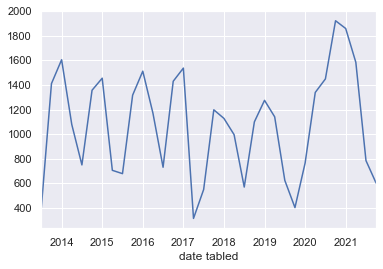

In [54]:
df.set_index('date tabled').resample('Q')['uri'].count().plot()

In [28]:
get_age = lambda x: 2021 - x.year
df['age'] = df['dob'].apply(get_age)

In [29]:
members = df[['age','party','gender']].drop_duplicates()

gender
Female    AxesSubplot(0.125,0.125;0.775x0.755)
Male      AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

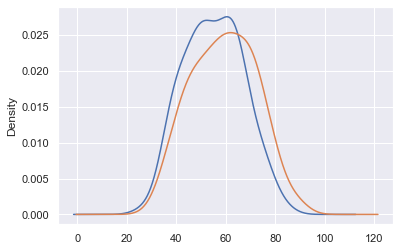

In [30]:
members.groupby('gender')['age'].plot(kind='density')

In [32]:
members[['age','gender']]

,age,gender
0,69,Male
87,52,Male
290,63,Male
335,43,Male
404,59,Male
...,...,...
36719,70,Male
36728,75,Male
36735,51,Male
36740,58,Female


/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


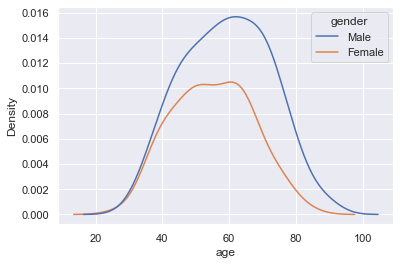

In [33]:
sns.kdeplot(x='age',hue='gender',data=members[['age','gender']])

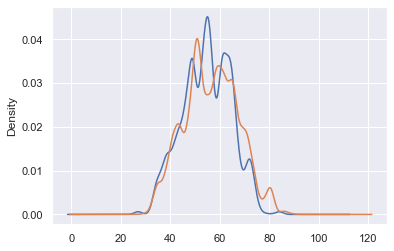

In [36]:
df[df.gender=='Female']['age'].plot(kind='density')
df[df.gender=='Male']['age'].plot(kind='density')

In [37]:
df.groupby(['answering body','gender'])

In [38]:
%matplotlib inline
by_gender = df.groupby(['answering body','gender'])['date tabled'].count()#.reset_index()
by_gender

answering body        gender
Attorney General      Female    224
                      Male      455
COP26                 Female     51
                      Male      112
Cabinet Office        Female    390
                               ... 
Treasury              Male      557
Wales Office          Female    184
                      Male      660
Women and Equalities  Female    440
                      Male      552
Name: date tabled, Length: 83, dtype: int64

In [39]:
probs = by_gender.groupby(level=1).apply(lambda x: x / float(x.sum()))
probs_df = probs.reset_index()

In [40]:
probs_df

,answering body,gender,date tabled
0,Attorney General,Female,0.019846
1,Attorney General,Male,0.017870
2,COP26,Female,0.004518
3,COP26,Male,0.004399
4,Cabinet Office,Female,0.034553
...,...,...,...
78,Treasury,Male,0.021877
79,Wales Office,Female,0.016302
80,Wales Office,Male,0.025922
81,Women and Equalities,Female,0.038983


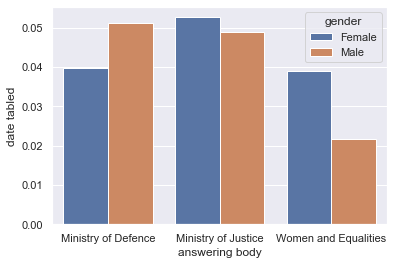

In [41]:
domains = ['Women and Equalities','Ministry of Defence','Ministry of Justice']
sns.barplot(x="answering body", y="date tabled", hue='gender', data=probs_df[probs_df['answering body'].isin(domains)])

In [24]:
by_gender.plot('')

TypeError: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='')` instead of `Series.plot('',)`.

In [26]:
df.groupby('gender')['age'].mad()

gender
Female    6.856617
Male      7.906342
Name: age, dtype: float64

In [1]:
df

NameError: name 'df' is not defined

In [37]:
by_mp = df.groupby(['uri_mp','answering body'])['uri'].count()
by_mp[:,'Ministry of Justice']

uri_mp
http://data.parliament.uk/members/114     7
http://data.parliament.uk/members/1170    1
http://data.parliament.uk/members/1198    8
http://data.parliament.uk/members/12      4
http://data.parliament.uk/members/1387    4
                                         ..
http://data.parliament.uk/members/602     4
http://data.parliament.uk/members/605     1
http://data.parliament.uk/members/69      1
http://data.parliament.uk/members/87      1
http://data.parliament.uk/members/93      2
Name: uri, Length: 437, dtype: int64

In [38]:
by_mp[:,'Ministry of Justice']

uri_mp
http://data.parliament.uk/members/114     7
http://data.parliament.uk/members/1170    1
http://data.parliament.uk/members/1198    8
http://data.parliament.uk/members/12      4
http://data.parliament.uk/members/1387    4
                                         ..
http://data.parliament.uk/members/602     4
http://data.parliament.uk/members/605     1
http://data.parliament.uk/members/69      1
http://data.parliament.uk/members/87      1
http://data.parliament.uk/members/93      2
Name: uri, Length: 437, dtype: int64

In [39]:
by_mp.groupby(['uri_mp']).sum()

uri_mp
http://data.parliament.uk/members/103      2
http://data.parliament.uk/members/104     14
http://data.parliament.uk/members/111      5
http://data.parliament.uk/members/114    118
http://data.parliament.uk/members/116     34
                                        ... 
http://data.parliament.uk/members/69      35
http://data.parliament.uk/members/76      23
http://data.parliament.uk/members/77       3
http://data.parliament.uk/members/87      21
http://data.parliament.uk/members/93      40
Name: uri, Length: 740, dtype: int64

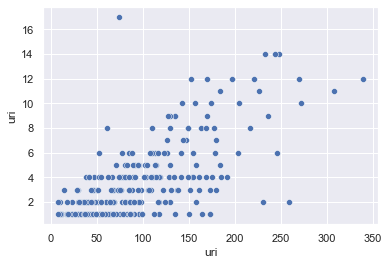

In [40]:
sns.scatterplot(x=by_mp.groupby(level=0).sum(),y=by_mp[:,'Women and Equalities'])

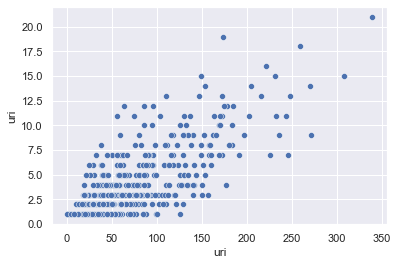

In [41]:
sns.scatterplot(x=by_mp.groupby(level=0).sum(),y=by_mp[:,'Ministry of Justice'])

In [56]:
by_mp = df.groupby(['uri_mp','answering body','gender'])['uri'].count()
#by_mp['t_count'] = df.groupby(['uri_mp','','gender'])['uri'].count()

In [61]:
by_mp_row = by_mp.unstack(level=1)

In [63]:
by_mp_row.fillna(0,inplace=True)


,answering body,Attorney General,COP26,Cabinet Office,Chancellor of the Duchy of Lancaster,Chancellor of the Duchy of Lancaster and Minister for the Cabinet Office,Church Commissioners,"Department for Business, Energy and Industrial Strategy","Department for Business, Innovation and Skills",Department for Communities and Local Government,"Department for Culture, Media and Sport",...,Ministry of Justice,Northern Ireland Office,Parliamentary Works Sponsor Body,Prime Minister,Public Accounts Commission,Scotland Office,Speaker's Committee on the Electoral Commission,Treasury,Wales Office,Women and Equalities
uri_mp,gender,,,,,,,,,,,,,,,,,,,,,
http://data.parliament.uk/members/103,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
http://data.parliament.uk/members/104,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0
http://data.parliament.uk/members/111,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://data.parliament.uk/members/114,Male,7.0,1.0,4.0,0.0,0.0,5.0,4.0,1.0,2.0,1.0,...,7.0,2.0,0.0,13.0,0.0,2.0,0.0,4.0,2.0,1.0
http://data.parliament.uk/members/116,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
http://data.parliament.uk/members/69,Male,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,...,1.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0
http://data.parliament.uk/members/76,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0
http://data.parliament.uk/members/77,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
by_mp_row['all'] = by_mp_row.sum(axis=1)

In [75]:
by_mp_row = by_mp_row.reset_index()

In [76]:
by_mp_row['gender']

0      Male
1      Male
2      Male
3      Male
4      Male
       ... 
735    Male
736    Male
737    Male
738    Male
739    Male
Name: gender, Length: 740, dtype: object

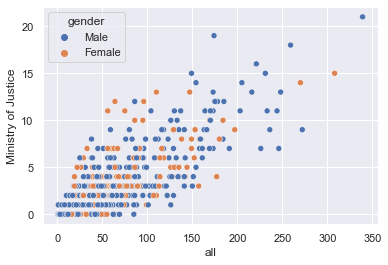

In [77]:
sns.scatterplot(x='all',y='Ministry of Justice',hue='gender',data=by_mp_row)

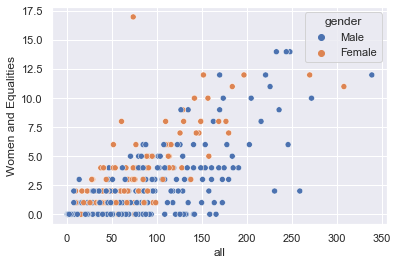

In [78]:
sns.scatterplot(x='all',y='Women and Equalities',hue='gender',data=by_mp_row)

In [90]:
import numpy as np


array([[  2.],
       [ 14.],
       [  5.],
       [118.],
       [ 34.],
       [  2.],
       [ 11.],
       [  4.],
       [  4.],
       [  2.],
       [ 76.],
       [ 52.],
       [  8.],
       [  8.],
       [  3.],
       [  2.],
       [ 16.],
       [ 10.],
       [  1.],
       [ 17.],
       [ 22.],
       [ 15.],
       [ 77.],
       [  1.],
       [  1.],
       [ 64.],
       [  7.],
       [ 22.],
       [ 10.],
       [ 53.],
       [ 32.],
       [  4.],
       [  1.],
       [102.],
       [ 20.],
       [ 24.],
       [ 23.],
       [ 28.],
       [  1.],
       [  5.],
       [ 48.],
       [  1.],
       [  9.],
       [  1.],
       [ 61.],
       [ 25.],
       [ 34.],
       [  7.],
       [ 14.],
       [ 10.],
       [ 21.],
       [161.],
       [180.],
       [  7.],
       [ 78.],
       [173.],
       [ 11.],
       [  9.],
       [ 94.],
       [ 56.],
       [ 20.],
       [  5.],
       [  4.],
       [  4.],
       [  9.],
       [ 37.],
       [ 1

In [91]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(np.array(by_mp_row['all'])[...,np.newaxis], np.array(by_mp_row['Women and Equalities'])[...,np.newaxis])



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [99]:
pd.DataFrame(by_mp_row['Women and Equalities']).assign(const=1)

,Women and Equalities,const
0,0.0,1
1,3.0,1
2,0.0,1
3,1.0,1
4,0.0,1
...,...,...
735,0.0,1
736,0.0,1
737,0.0,1
738,0.0,1


In [101]:
import statsmodels.api as sm

model = sm.OLS(np.array(by_mp_row['Women and Equalities']), pd.DataFrame(by_mp_row['all']).assign(const=1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     1004.
Date:                Mon, 27 Dec 2021   Prob (F-statistic):          8.70e-140
Time:                        11:26:20   Log-Likelihood:                -1411.6
No. Observations:                 740   AIC:                             2827.
Df Residuals:                     738   BIC:                             2836.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
all            0.0356      0.001     31.688      0.000       0.033       0.038
const         -0.4295      0.082     -5.239      0.000      -0.590      -0.269
==============================================================================
Omnibus:                      293.549   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4534.645
Skew:                           1.356   Prob(JB):                         0.00
Kurtosis:                      14.820   Cond. No.                         99.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
model.coef_

array([[0.03564446]])

In [93]:
model.intercept_

array([-0.42954414])

In [106]:
by_mp_row[:10]

answering body,uri_mp,gender,Attorney General,COP26,Cabinet Office,Chancellor of the Duchy of Lancaster,Chancellor of the Duchy of Lancaster and Minister for the Cabinet Office,Church Commissioners,"Department for Business, Energy and Industrial Strategy","Department for Business, Innovation and Skills",...,Northern Ireland Office,Parliamentary Works Sponsor Body,Prime Minister,Public Accounts Commission,Scotland Office,Speaker's Committee on the Electoral Commission,Treasury,Wales Office,Women and Equalities,all
0,http://data.parliament.uk/members/103,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,http://data.parliament.uk/members/104,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,14.0
2,http://data.parliament.uk/members/111,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,http://data.parliament.uk/members/114,Male,7.0,1.0,4.0,0.0,0.0,5.0,4.0,1.0,...,2.0,0.0,13.0,0.0,2.0,0.0,4.0,2.0,1.0,118.0
4,http://data.parliament.uk/members/116,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,34.0
5,http://data.parliament.uk/members/1166,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
6,http://data.parliament.uk/members/117,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
7,http://data.parliament.uk/members/1170,Female,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
8,http://data.parliament.uk/members/1171,Male,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
9,http://data.parliament.uk/members/1191,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [121]:
by_mp_row.corr()['all']

answering body
Attorney General                                                            0.768516
COP26                                                                       0.495064
Cabinet Office                                                              0.827445
Chancellor of the Duchy of Lancaster                                        0.080351
Chancellor of the Duchy of Lancaster and Minister for the Cabinet Office    0.361069
Church Commissioners                                                        0.483297
Department for Business, Energy and Industrial Strategy                     0.778503
Department for Business, Innovation and Skills                              0.511141
Department for Communities and Local Government                             0.564158
Department for Culture, Media and Sport                                     0.594660
Department for Digital, Culture, Media and Sport                            0.779572
Department for Education                          

In [108]:
X = pd.get_dummies(by_mp_row[['gender','Women and Equalities','all']],drop_first=True)
X

,Women and Equalities,all,gender_Male
0,0.0,2.0,1
1,3.0,14.0,1
2,0.0,5.0,1
3,1.0,118.0,1
4,0.0,34.0,1
...,...,...,...
735,0.0,35.0,1
736,0.0,23.0,1
737,0.0,3.0,1
738,0.0,21.0,1


In [110]:
model = sm.OLS(np.array(X['Women and Equalities']), pd.DataFrame(X[['all','gender_Male']]).assign(const=1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     553.6
Date:                Mon, 27 Dec 2021   Prob (F-statistic):          1.61e-147
Time:                        11:31:32   Log-Likelihood:                -1390.1
No. Observations:                 740   AIC:                             2786.
Df Residuals:                     737   BIC:                             2800.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
all             0.0354      0.001     32.380      0.000       0.033       0.038
gender_Male    -0.8538      0.128     -6.652      0.000      -1.106      -0.602
const           0.1863      0.122      1.525      0.128      -0.053       0.426
==============================================================================
Omnibus:                      288.294   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4105.441
Skew:                           1.348   Prob(JB):                         0.00
Kurtosis:                      14.220   Cond. No.                         208.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [115]:
X = pd.get_dummies(by_mp_row[['gender','COP26','all']],drop_first=True)
model = sm.OLS(np.array(X['COP26']), pd.DataFrame(X[['all','gender_Male']]).assign(const=1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     119.6
Date:                Mon, 27 Dec 2021   Prob (F-statistic):           1.01e-45
Time:                        11:32:55   Log-Likelihood:                -605.83
No. Observations:                 740   AIC:                             1218.
Df Residuals:                     737   BIC:                             1231.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
all             0.0059      0.000     15.460      0.000       0.005       0.007
gender_Male    -0.0009      0.044     -0.020      0.984      -0.088       0.086
const          -0.0701      0.042     -1.656      0.098      -0.153       0.013
==============================================================================
Omnibus:                      525.377   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8575.405
Skew:                           3.030   Prob(JB):                         0.00
Kurtosis:                      18.537   Cond. No.                         208.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
df.groupby('uri_mp')['uri'].count()

uri_mp
http://data.parliament.uk/members/103      2
http://data.parliament.uk/members/104     14
http://data.parliament.uk/members/111      5
http://data.parliament.uk/members/114    118
http://data.parliament.uk/members/116     34
                                        ... 
http://data.parliament.uk/members/69      35
http://data.parliament.uk/members/76      23
http://data.parliament.uk/members/77       3
http://data.parliament.uk/members/87      21
http://data.parliament.uk/members/93      40
Name: uri, Length: 740, dtype: int64

In [116]:
from statsmodels.discrete.discrete_model import NegativeBinomial

In [118]:
X = pd.get_dummies(by_mp_row[['gender','Women and Equalities','all']],drop_first=True)
model = NegativeBinomial(np.array(X['Women and Equalities']), pd.DataFrame(X[['all','gender_Male']]).assign(const=1))
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 1.187442
         Iterations: 17
         Function evaluations: 20
         Gradient evaluations: 20


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                      y   No. Observations:                  740
Model:               NegativeBinomial   Df Residuals:                      737
Method:                           MLE   Df Model:                            2
Date:                Mon, 27 Dec 2021   Pseudo R-squ.:                  0.2028
Time:                        11:36:50   Log-Likelihood:                -878.71
converged:                       True   LL-Null:                       -1102.2
Covariance Type:            nonrobust   LLR p-value:                 8.382e-98
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
all             0.0199      0.001     19.782      0.000       0.018       0.022
gender_Male    -0.8209      0.105     -7.786      0.000      -1.028      -0.614
const          -0.8186      0.108     -7.607      0.000      -1.030      -0.608
alpha           0.6153      0.093      6.582      0.000       0.432       0.799
===============================================================================
"""

In [131]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
X = pd.get_dummies(by_mp_row[['gender','Women and Equalities','all']],drop_first=True)
X.columns = ['response','all','gender']
X

,response,all,gender
0,0.0,2.0,1
1,3.0,14.0,1
2,0.0,5.0,1
3,1.0,118.0,1
4,0.0,34.0,1
...,...,...,...
735,0.0,35.0,1
736,0.0,23.0,1
737,0.0,3.0,1
738,0.0,21.0,1


In [137]:
model = smf.glm(formula='response ~ gender + all', data=X, family=sm.families.NegativeBinomial())
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                  740
Model:                            GLM   Df Residuals:                      737
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -884.37
Date:                Mon, 27 Dec 2021   Deviance:                       522.56
Time:                        12:00:25   Pearson chi2:                     595.
No. Iterations:                    13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9093      0.113     -8.039      0.000      -1.131      -0.688
gender        -0.8269      0.121     -6.834      0.000      -1.064      -0.590
all            0.0211      0.001     23.369      0.000       0.019       0.023
==============================================================================
"""

In [145]:
-np.exp(0.8269) * 100

-228.62204601880202

In [141]:
np.exp(0.0211)

1.0213241789489729

In [119]:
np.exp(-0.8209)

0.4400354443382635